# Final Project - TRON Tournament

## 1. Set-up

In [1]:
# Import any libraries you might need to develop our agent.
import numpy as np
import matplotlib
import time
import signal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML, clear_output
import random
from collections import deque
from queue import Queue

## 2. Agent

The task is to implement an agent using a technique discussed during the class. Your agent should be able to beat random player ~99% of the time, and must comply with a  time limit of 5 seconds per move. Furthermore, you cannot modify the game board directly; any projects that do so that will be disqualified.

In [2]:
# TODO: Implement your agent here by modifying the 'choose_move' function.
# Do not change the instantiation function or any of the function signatures.
class PlayerAgent:
    def __init__(self, player_id, iterative_max_depth=10):
        self.player_id = player_id
        self.iterative_max_depth = iterative_max_depth
        self.board_size = 0
        self.game = 0

    def bfs(self, board):
        position_x, position_y, enemy_x, enemy_y = self.get_position_by_board(board)
        frontier = Queue()
        frontier.put((position_x, position_y))
        expanded_set = set()
        while not frontier.empty():
            current_board = frontier.get()
            if current_board[0] == enemy_x and current_board[1] == enemy_y:
                return True
            elif str(current_board) not in expanded_set:
                for move in self.get_legal_moves_tree(board, self.player_id):
                    board_tmp = self.examine_move_tree(board, move, self.player_id)
                    if str(board_tmp) not in expanded_set:
                        x, y, _, _ = self.get_position_by_board(board_tmp)
                        frontier.put((x, y))
                expanded_set.add(str(current_board))
        return False

    def choose_move(self, game):
        # Get an array of legal moves from your current position.
        self.board_size = game.size
        self.game = game

        return self.find_best_move(game)
        # Choose an action to take based on the algorithm you
        # decide to implement. This method should return
        # one of the items in the 'legal_moves' array.
    
    # get the position of player
    def get_position_by_board(self, board):
        position_x = np.where(board == self.player_id)[0][0]
        position_y = np.where(board == self.player_id)[1][0]
        enemy_x = np.where(board == self.game.agent2.player_id)[0][0]
        enemy_y = np.where(board == self.game.agent2.player_id)[1][0]
        return position_x, position_y, enemy_x, enemy_y
    
    # examine move by player
    def examine_move_tree(self, board, move, player):
        board2 = board.copy()
        if player == self.player_id:
            position_x = np.where(board == self.player_id)[0][0]
            position_y = np.where(board == self.player_id)[1][0]
            board2[position_x, position_y] = 4
            board2[move[0], move[1]] = player
        else:
            enemy_x = np.where(board == self.game.agent2.player_id)[0][0]
            enemy_y = np.where(board == self.game.agent2.player_id)[1][0]
            board2[enemy_x, enemy_y] = 4
            board2[move[0], move[1]] = player
        return board2
    
    # ununsed here; 
    def escape_from_corner(self, board, position_x, position_y):
        total = 0
        if len(self.get_legal_moves_tree(board, self.player_id)) == 1:
            total -= 0.5
        if len(self.get_legal_moves_tree(board, self.player_id)) == 3:
            total += 0.25
        if not (0 < position_x < self.board_size - 1 and 0 < position_y < self.board_size - 1):
            total -= 0.1
        return total

    def grid_neighbors(self, row, col):
        maxrow = self.board_size
        maxcol = self.board_size
        l = []
        if (row + 1 < maxrow):
            l += [(row + 1, col)]
        if (row > 0):
            l += [(row - 1, col)]
        if (col + 1 < maxcol):
            l += [(row, col + 1)]
        if (col > 0):
            l += [(row, col - 1)]
        return l
    
    # use dijkstra algorithm to get the distance of every point
    def dijkstra(self, board, x, y):
        distance = np.zeros((self.board_size, self.board_size))
        distance[:] = np.inf
        distance[x, y] = 0
        visited = np.zeros((self.board_size, self.board_size))
        # get neighborhood point
        neighbor = self.grid_neighbors(x, y)
        for n in neighbor:
            r, c = n
            distance[r, c] = 1
        q = deque(self.grid_neighbors(x, y))

        # use queue to boost dijkstra algorithm
        while len(q) != 0:
            cr, cc = q.popleft()
            ndist = distance[cr, cc] + 1
            for n in self.grid_neighbors(cr, cc):
                nr, nc = n
                # check status
                if (board[nr, nc] != 0):
                    continue
                # update distance
                if ndist < distance[nr, nc]:
                    distance[nr, nc] = ndist
                # check visited
                if visited[nr, nc] == 0:
                    q.append(n)
                    visited[nr, nc] = 1
        return distance

    # voronoi algorithm
    def compute_voronoi(self, board):
        position_x, position_y, enemy_x, enemy_y = self.get_position_by_board(board)
        player_costs = self.dijkstra(board, position_x, position_y)
        op_costs = self.dijkstra(board, enemy_x, enemy_y)
        pcount = 0
        opcount = 0
        maxcost = self.board_size * 2
        for r in range(self.board_size):
            for c in range(self.board_size):
                if player_costs[r, c] < op_costs[r, c] and player_costs[r, c] <= maxcost:
                    pcount += 1
                if op_costs[r, c] < player_costs[r, c] and op_costs[r, c] <= maxcost:
                    opcount += 1

        v = (pcount - opcount)
        return v

    def get_empty(self, board, depth, total):
        if depth <= 0:
            return total
        total += len(self.get_legal_moves_tree(board, self.player_id))
        for move in self.get_legal_moves_tree(board, self.player_id):
            board_tmp = self.examine_move_tree(board, move, self.player_id)
            total = self.get_empty(board_tmp, depth-1, total)
        return total
    
    # heuristic function
    def evaluate(self, board, player_id, connected):
        position_x, position_y, enemy_x, enemy_y = self.get_position_by_board(board)
        if not (-1 < position_x < self.board_size and -1 < position_y < self.board_size):
            if player_id == self.player_id:
                return -1000, True
            else:
                return 1000, True

        #return 0, False
        if player_id == self.player_id:
            # return self.compute_voronoi(board) + self.escape_from_corner(board, position_x, position_y), False
            if connected == "connected":
                return self.compute_voronoi(board), False
            else:
                return self.get_empty(board, 5, 0), False
        else:
            return random.random(), False


    def get_legal_moves_tree(self, board, player):
        position_x, position_y, enemy_x, enemy_y = self.get_position_by_board(board)
        moves = []
        if player == self.player_id:
            x = position_x
            y = position_y
        else:
            x = enemy_x
            y = enemy_y
        if (x != 0) and (board[x - 1, y] == 0):
            moves.append([x - 1, y])
        if (x != self.board_size - 1) and (board[x + 1, y] == 0):
            moves.append([x + 1, y])
        if (y != 0) and (board[x, y - 1] == 0):
            moves.append([x, y - 1])
        if (y != self.board_size - 1) and (board[x, y + 1] == 0):
            moves.append([x, y + 1])
        return moves

    def minimax_pruning(self, board, max_or_min, player, alpha, beta, depth, connected):
        score, is_finish = self.evaluate(board, player, connected)
        if is_finish or len(self.get_legal_moves_tree(board, player)) == 0 or depth <= 0:
            return score
        if player == self.player_id:
            player = 3
        else:
            player = 1
        if max_or_min == "max":
            best = -1000
            for move in self.get_legal_moves_tree(board, player):
                board_tmp = self.examine_move_tree(board, move, player)
                best = max(best, self.minimax_pruning(board_tmp, "min", player, alpha, beta, depth-1, connected))
                alpha = max(best, alpha)
                if alpha >= beta:
                    break
            return best
        else:
            best = 1000
            for move in self.get_legal_moves_tree(board, player):
                board_tmp = self.examine_move_tree(board, move, player)
                best = min(best, self.minimax_pruning(board_tmp, "max", player, alpha, beta, depth-1, connected))
                beta = min(best, beta)
                if alpha >= beta:
                    break
            return best

    # iterative deepening search with pruning
    def find_best_move(self, game):
        best_mov = game.get_legal_moves(self.player_id)[0]
        startTime = time.time()
        for depth in range(1, self.iterative_max_depth):
            best_val = -1000
            for move in game.get_legal_moves(self.player_id):
                board_tmp = self.examine_move_tree(game.board, move, self.player_id)
                if self.bfs(game.board) == True:
                    mov_val = self.minimax_pruning(board_tmp, "max", self.player_id, -1000, 1000, depth, "connected")
                else:
                    mov_val = self.minimax_pruning(board_tmp, "max", self.player_id, -1000, 1000, depth, "disconnected")
                if mov_val > best_val:
                    best_mov = move
                    best_val = mov_val
            # if process time bigger than 0.8, break
            if time.time() - startTime > 0.8:
                #print("more than 0.8 here, break")
                break
        return best_mov


# This is an example of an agent which simply picks a move at random.
class RandomAgent:

    def __init__(self, player_id):
        self.player_id = player_id

    def choose_move(self, game):
        # Get an array of legal moves from your current position.
        legal_moves = game.get_legal_moves(self.player_id)
        
        # Shuffle the legal moves and pick the first one. This is equivalent
        # to choosing a move randomly with no logic.
        np.random.shuffle(legal_moves)
        return legal_moves[0]

## 3. Environment

This is the game environment. It will probably be helpful to have an understanding of how the game works,
so we reccomend reading through the implementation.

**!!!!! Do not modify the game's implementation !!!!!**


In [3]:
# This handler will be used to time-out actions/games which take too long to compute.
# Note that this handler does not function on Windows based systems.
def signal_handler(signum, frame):
    raise TimeoutError("Timed out!")
#signal.signal(signal.SIGALRM, signal_handler)


class TronGame:

    def __init__(self, agent1_class, agent2_class, board_size, board_type):
        # Default board.
        if board_type == 'default':
            self.size = board_size
        # Board with obstacles and a fixed size of 10x10.
        elif board_type == 'obstacles':
            self.size = 10
        elif board_type == 'rocky':
            self.size = board_size            
        else:
            raise ValueError('Invalid board type.')

        # Build the game board.
        self.board_type = board_type
        self.board = self.build_board(board_type)

        # Initialize the game state variables and set the values using the 
        # 'reset_game()' method.
        self.reset_game()

        # Initialize our agents.
        self.agent1 = agent1_class(1)
        self.agent2 = agent2_class(3)

    def build_board(self, board_type):
        """
        This method takes a board_type: ['default', 'obstacles'] and returns a 
        new board (NumPy matrix).
        """

        # Default board.
        if board_type == 'default':
            board = np.zeros((self.size, self.size))
            board[0, 0] = 1
            board[self.size - 1, self.size - 1] = 3

        # Board with obstacles and a fixed size of 10x10.
        elif board_type == 'obstacles':
            board = np.zeros((10, 10))
            board[1, 4] = 1
            board[8, 4] = 3
            board[3:7, 0:4] = 4
            board[3:7, 6:] = 4
        # Board with obstacles and a fixed size of 10x10.
        elif board_type == 'rocky':
            board = np.zeros((self.size, self.size))
            a=np.random.randint(2,size=(self.size,self.size))
            b=np.random.randint(2,size=(self.size,self.size))
            c=np.random.randint(2,size=(self.size,self.size))
            d=np.random.randint(2,size=(self.size,self.size))

            board=board+(a*b*c*d)*4
            board[0, 0] = 1
            board[self.size-1, self.size-1] = 3
                      

        else:
            raise ValueError('Invalid board type.')

        return board

    def reset_game(self):
        """ 
        Helper method which re-initializes the game state.
        """
        
        self.board = self.build_board(self.board_type)

    def get_player_position(self, player_id, board=None):
        """
        Helper method which finds the coordinate of the specified player ID
        on the board.
        """
        
        if board is None:
            board = self.board
        coords = np.asarray(board == player_id).nonzero()
        coords = np.stack((coords[0], coords[1]), 1)
        coords = np.reshape(coords, (-1, 2))
        return coords[0]

    def get_legal_moves(self, player, board=None):
        """
        This method returns a list of legal moves for a given player ID and
        board.
        """
        
        if board is None:
            board = self.board

        # Get the current player position and then check for all possible
        # legal moves.
        prev = self.get_player_position(player)
        moves = []
        
        # Up
        if (prev[0] != 0) and (board[prev[0] - 1, prev[1]] == 0):
            moves.append([prev[0] - 1, prev[1]])
        # Down
        if (prev[0] != self.size - 1) and (board[prev[0] + 1, prev[1]] == 0):
            moves.append([prev[0] + 1, prev[1]])
        # Left
        if (prev[1] != 0) and (board[prev[0], prev[1] - 1] == 0):
            moves.append([prev[0], prev[1] - 1])
        # Right
        if (prev[1] != self.size - 1) and (board[prev[0], prev[1] + 1] == 0):
            moves.append([prev[0], prev[1] + 1])
            
        return moves

    def examine_move(self, player, coordinate, board):
        board_clone = board.copy()
        prev = self.get_player_position(player, board_clone)
        board_clone[prev] = 4
        board_clone[coordinate] = player
        return board_clone

    @staticmethod
    def view_game(board_history):
        """
        This is a helper function which takes a board history 
        (i.e., a list of board states) and creates an animation of the game 
        as it progresses.
        """

        fig, ax = plt.subplots()
        colors = ['black', 'blue', 'pink', 'white', 'red', 'yellow']
        cmap = matplotlib.colors.ListedColormap(colors)
        bounds = np.linspace(0, 5, 6)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        matrix = ax.matshow(board_history[0], cmap=cmap, norm=norm)

        def update(i):
            matrix.set_array(board_history[i])
            return matrix

        ani = FuncAnimation(fig, update, frames=len(board_history), interval=100)
        plt.show()
        return HTML(ani.to_html5_video())

    def play_series(self, num_games, debug=True):
        """
        This method plays a series of games between the two agents.

        It returns two objects: (i) a tuple which indicates the number of 
        wins per player, and (ii) a history of the board state as the game 
        progresses.
        """

        wins_player_1 = 0
        wins_player_2 = 0
        games = []
        for i in range(num_games):
            winning_player_id, board_history = self.__play_game(debug=debug)
            games.append(board_history)

            if winning_player_id == 1:
                wins_player_1 += 1
            elif winning_player_id == 2:
                wins_player_2 += 1
            else:
                raise ValueError('Invalid winning player ID.')

        print(f'Finished playing [{num_games}] games.')
        print(f'Player 1 won [{wins_player_1}] games and has a win-rate of [{wins_player_1 / num_games * 100}%].')
        print(f'Player 2 won [{wins_player_2}] games and has a win-rate of [{wins_player_2 / num_games * 100}%].')
        return (wins_player_1, wins_player_2), games

    def __apply_move(self, player, coordinate):
        """
        This private method moves a player ID to a new coordinate and obstructs
        the previously occupied tile.
        """
        
        prev_coord = self.get_player_position(player)

        self.board[prev_coord[0], prev_coord[1]] = 4
        self.board[coordinate[0], coordinate[1]] = player

    def __play_game(self, debug=True):
        """
        This private method plays a single game between the two agents. It
        returns the winning player ID as well as the history of the board
        as the game progresses.
        """
        
        # Reset the game.
        self.reset_game()
        board_history = []

        # Play the game until it's conclusion.
        while True:
            # ---------------------------------------
            # PLAYER 1's TURN
            # ---------------------------------------
            # Check legal moves.
            poss_moves = self.get_legal_moves(1)
            if not len(poss_moves):
                if debug:
                    print("Player 2 wins")
                winning_player_id = 2
                break

            # Compute and apply the chosen move.
            signal.alarm(3)
            try:
                move = self.agent1.choose_move(self)
            except Exception:
                print("There was an error while choosing a move.")
                print("Player 2 wins")
                winning_player_id = 2
                break
            self.__apply_move(1, move)
            
            # Record keeping.
            board_history.append(np.array(self.board.copy()))
            if debug:
                print(self.board)
                time.sleep(.5)
                clear_output()

            # ---------------------------------------
            # PLAYER 2's TURN
            # ---------------------------------------
            # Check legal moves.
            poss_moves = self.get_legal_moves(3)
            if not len(poss_moves):
                if debug:
                    print("Player 1 wins")
                winning_player_id = 1
                break
                
            # Compute and apply the chosen move.
            signal.alarm(3)
            try:
                move = self.agent2.choose_move(self)
            except Exception:
                print("There was an error while choosing a move.")
                print("Player 1 wins")
                winning_player_id = 1
                break
            self.__apply_move(3, move)

            # Record keeping.
            board_history.append(np.array(self.board.copy()))
            if debug:
                print(self.board)
                time.sleep(.5)
                clear_output()
        signal.alarm(0)

        return winning_player_id, board_history

## 4. Development

In [4]:
my_tron_game = TronGame(board_size=20,
                        agent1_class=PlayerAgent,
                        agent2_class=RandomAgent,
                        board_type='rocky')

(player1_wins, player2_wins), game_histories = my_tron_game.play_series(num_games=50, debug=False)

Finished playing [50] games.
Player 1 won [48] games and has a win-rate of [96.0%].
Player 2 won [2] games and has a win-rate of [4.0%].


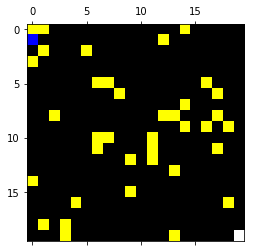

In [7]:
TronGame.view_game(game_histories[4])